In [4]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"]    = boxes
        target["labels"]   = labels
        target["masks"]    = masks
        target["image_id"] = image_id
        target["area"]     = area
        target["iscrowd"]  = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

dataset      = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

### common 

In [1]:
import torchvision , torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from rcnn_transfrom import InterpolationTransform as it

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cuda:0'
num_classes = 2

def get_instance_segmentation_model(num_classes,pretrained=True,mode='bilinear'):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    model.transform = it(min_size=(800,), max_size=1333,image_mean=[0.485, 0.456, 0.406],image_std=[0.229, 0.224, 0.225],mode=mode)
    return model

### inference 

In [1]:
# Squeeze 'Inference' visualization 
import torchvision , torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from rcnn_transfrom import InterpolationTransform as it

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cuda:0'
num_classes = 2

def get_instance_segmentation_model(num_classes,pretrained=True,mode='bilinear'):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    model.transform = it(min_size=(800,), max_size=1333,image_mean=[0.485, 0.456, 0.406],image_std=[0.229, 0.224, 0.225],mode=mode)
    return model

bicubic_m = get_instance_segmentation_model(num_classes,pretrained=False,mode='bicubic')
bicubic_m.to(device)
m_path = './model/pf_4_bicubic.pth'
bicubic_pter = torch.load(m_path)

bicubic_m.load_state_dict(bicubic_pter['model_state_dict'])

## sample load
# -sample0
from PIL import Image
path = './sample/pds.jpg'
img = Image.open(path).convert("RGB")

## pil > tensor
from torchvision.transforms import functional as fc
imt = fc.to_tensor(img).to(device = 'cuda')

# -sample1
from PIL import Image
path0 = './sample/pds0.jpg'
img0 = Image.open(path0).convert("RGB")

## pil > tensor
from torchvision.transforms import functional as fc
imt0 = fc.to_tensor(img0).to(device = 'cuda')

## prediction
bicubic_m.eval()
pre = bicubic_m([imt])
pre0 = bicubic_m([imt0])

/home/yp/anaconda3/envs/tor1.9/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


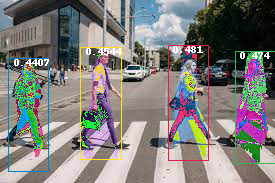

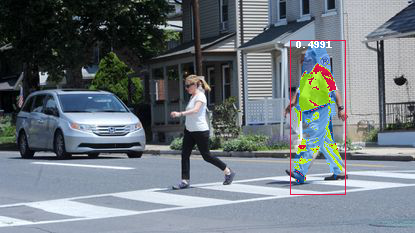

In [45]:
import torchvision
from PIL import Image, ImageDraw, ImageFont
import numpy as np
def detect(img,scores,boxes,masks=None,nms=True,iou_threshold=0.5,conf_threshold=0.4 ,mask_threshold=0.5): # pil , tensor,tensor,float

    dis_rgbs = [(230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60), (250, 190, 212), (0, 128, 128),
        (220, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (255, 255, 255), (0, 0, 0)]
    msk  = masks is not None
    size = img.size[::-1]

    # nms
    if nms :
        idx = torchvision.ops.nms(boxes,scores,iou_threshold=0.3)
        boxes  = boxes[idx]
        scores = scores[idx]
        if msk :
            masks = masks[idx]
    if conf_threshold :
        condition = scores>conf_threshold
        boxes  = boxes[condition]
        scores = scores[condition]   
        if msk :
            masks = masks[condition]
    if msk :
        if  'cuda' in masks.device.type:
            masks = masks.clone().detach().cpu()
        summask = np.zeros(size+(3,),dtype='uint8')
        for i,mask in enumerate(masks): 
            condi      = np.array(mask>0.5)
            condi_3    = np.concatenate([condi.reshape(size+(1,) )]*3,axis=2)
            colorMask  = np.array(Image.new('RGB',(size[1],size[0]),dis_rgbs[i]) )
            colorMask  = colorMask * condi_3 

            # multiply 1/2 if overlapped        
#             overlapped = (colorMask.sum(0) * summask.sum(0)).astype('bool')
#             overlapped = np.stack([overlapped,overlapped,overlapped]).reshape( num_condi.shape+(3,))
#             overMask   = colorMask*overlapped//2 + summask*overlapped//2
#             summask    = summask*(~overlapped) + colorMask*(~overlapped)
#             summask    = summask + overMask
            summask    = summask + (colorMask)
        # summask brightness
#         overlapped = 
#         imgnp , summask = np.array(img)[overlapped]//2 + summask[overlapped]//2
        
        imgnp           = np.array(img)
        img = Image.fromarray(imgnp+summask ) 
    
    annimg = img.copy()
    draw = ImageDraw.Draw(annimg)
    font = ImageFont.load_default()
    
    for i,box in enumerate(boxes):
        # draw.rectangle(xy=[0,0,150,150],outline=dis_rgb[2] )#, outline=label_color_map[det_labels[i]])
        box_xy = box.tolist()
        draw.rectangle(xy=box_xy,outline=dis_rgbs[i%len(dis_rgbs)] )#, outline=label_color_map[det_labels[i]])
        title = str(round(scores[i].item(),4))
        draw.text(xy=[box_xy[0]+len(title),box_xy[1]-1],text=title,fill='white',font=font)
    del draw
        
    
    return annimg
annimg = detect(img,pre[0]['scores'],pre[0]['boxes'],pre[0]['masks'].cpu(),nms=True,conf_threshold=0.4)
annimg0 = detect(img0,pre0[0]['scores'],pre0[0]['boxes'],pre0[0]['masks'].cpu())
from IPython.display import display
display(annimg)
display(annimg0)

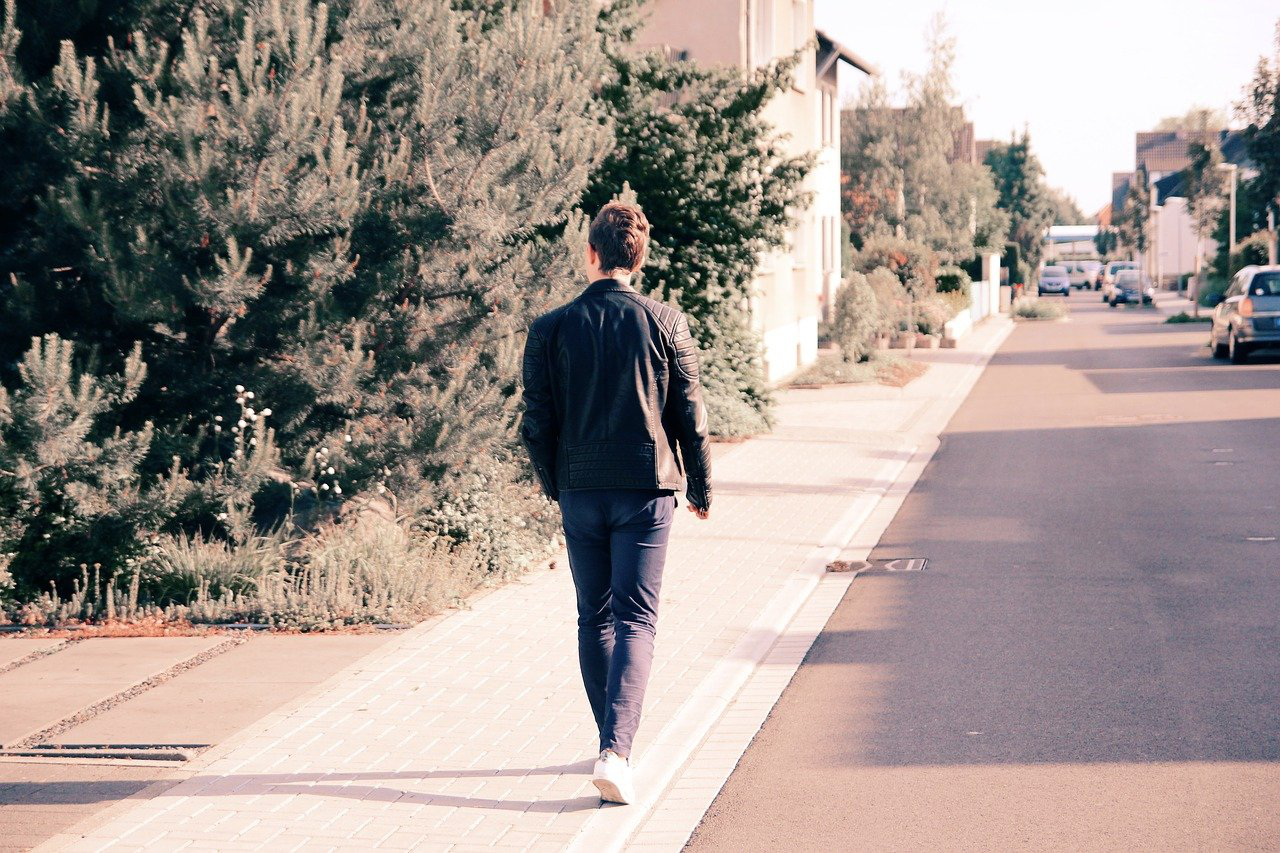

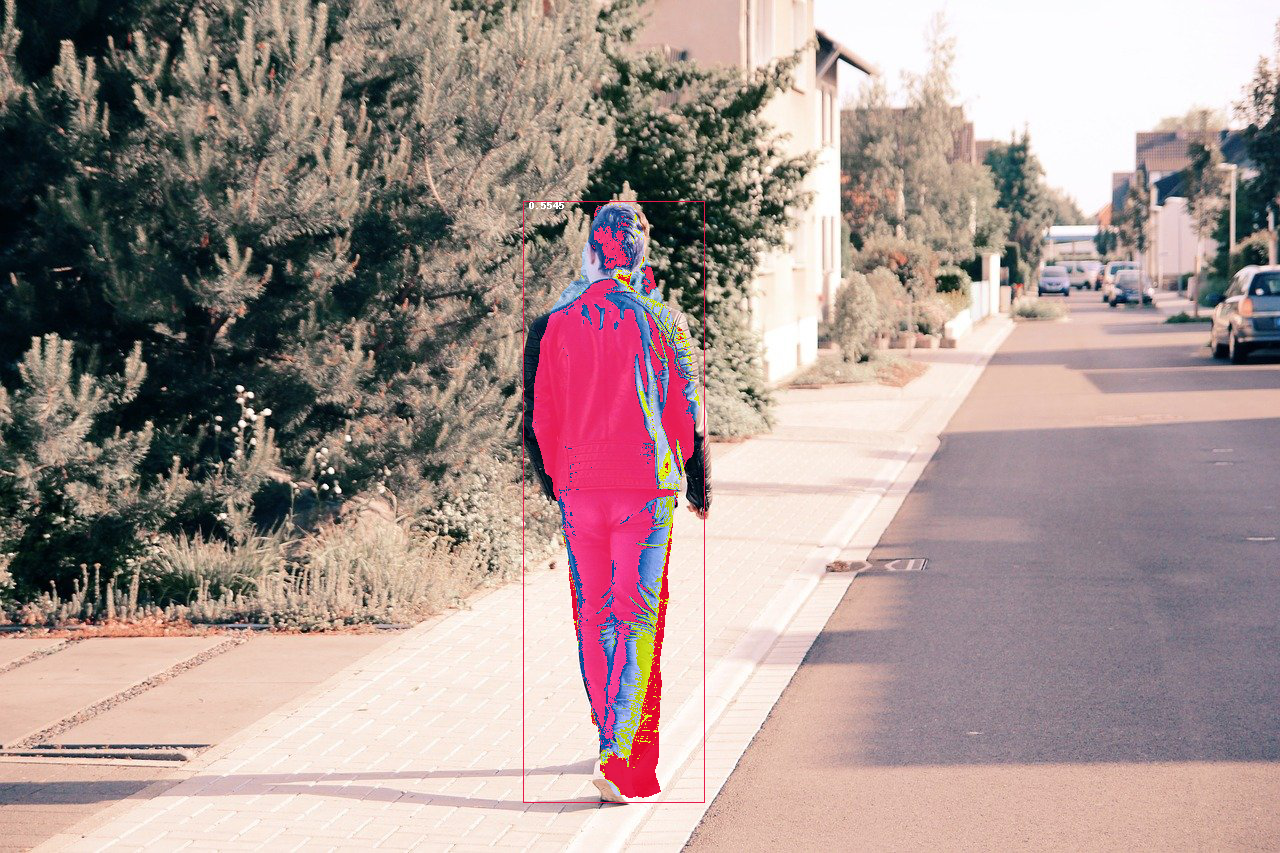

In [31]:
from torchvision.transforms import functional as fc
from IPython.display import display
import requests as rq
from PIL import Image
import io

img_url ='https://cdn.pixabay.com/photo/2017/08/10/04/44/pedestrian-2618280_1280.jpg'
imu = Image.open(io.BytesIO(rq.get(img_url).content ))
display(imu)
imut   = fc.to_tensor(imu).to(device = 'cuda')
preimu = bicubic_m([imut])
annimg = detect(imu,preimu[0]['scores'],preimu[0]['boxes'],preimu[0]['masks'].cpu())
display(annimg)

In [34]:
annimg.save('pedkiller.jpg')

In [127]:
## NMS
import torchvision

idx = torchvision.ops.nms(pre[0]['boxes'],pre[0]['scores'],iou_threshold=0.3)
# issue all of inputs is output......
# detect : mask,bbox (,label)

In [131]:
nms_boxes = pre[0]['boxes'][idx].shape

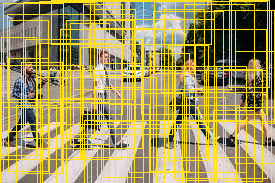

In [125]:
dis_rgbs = [(230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60), (250, 190, 212), (0, 128, 128),
            (220, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (255, 255, 255), (0, 0, 0)]

from PIL import Image, ImageDraw, ImageFont

for box in nms_boxes:
    annimg = img
    draw = ImageDraw.Draw(annimg)
    font = ImageFont.load_default()

    # draw.rectangle(xy=[0,0,150,150],outline=dis_rgb[2] )#, outline=label_color_map[det_labels[i]])
    draw.rectangle(xy=box.tolist(),outline=dis_rgb[2] )#, outline=label_color_map[det_labels[i]])
    del draw
annimg

In [ ]:
from PIL import Image, ImageDraw, ImageFont

annotated_image = original_image
draw = ImageDraw.Draw(annotated_image)
font = ImageFont.load_default()
# font = ImageFont.truetype("arial.ttf", 15)
# font = ImageFont.truetype("calibril.ttf", 15)

# Suppress specific classes, if needed
for i in range(det_boxes.size(0)):
    if suppress is not None:
        if det_labels[i] in suppress:
            continue

    # Boxes
    box_location = det_boxes[i].tolist()
    draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
    draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
        det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
    # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
    #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
    # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
    #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

    # Text
    text_size = font.getsize(det_labels[i].upper())
    text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
    textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                        box_location[1]]
    draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
    draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
              font=font)
del draw


In [14]:
pre[0]['masks'].shape,pre0[0]['masks'].shape

(torch.Size([60, 1, 183, 275]), torch.Size([35, 1, 233, 415]))

### transform layer 

In [6]:
# Transform layer hunter 
bicubic_m = get_instance_segmentation_model(num_classes,pretrained=False,mode='bicubic')
bicubic_m.to(device)
m_path = './model/pf_4_bicubic.pth'
bicubic_pter = torch.load(m_path)

bicubic_m.load_state_dict(bicubic_pter['model_state_dict'])
dl_it = iter(data_loader)

In [7]:
## Transfrom : resize ,batch 
x,y   = next(dl_it)

imgs = list(image.to(device) for image in x)
tgs = [{k: v.to(device) for k, v in t.items()} for t in y]

print(f'images {len(imgs)}')
for img in imgs:
    print(f'{img.shape}')

bicubic_m.eval()
imt = bicubic_m.transform(imgs)

print(f'resize : {imt[0].image_sizes}')
vimgs = [torch.rand((3,)+size) for size in imt[0].image_sizes ]

images 4
torch.Size([3, 334, 324])
torch.Size([3, 353, 417])
torch.Size([3, 454, 767])
torch.Size([3, 482, 550])
resize : [(824, 800), (800, 945), (789, 1333), (800, 912)]


In [8]:
from torchvision.models.detection.transform import  GeneralizedRCNNTransform as grt
rt = grt(800,1333,[0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
max_size = rt.max_by_axis([list(img.shape) for img in vimgs])
print(f'max size : {max_size}')
batimgs = rt.batch_images(vimgs)
print(f'batched size : {batimgs.shape}')
print(f'transform : {imt[0].tensors.shape}')

max size : [3, 824, 1333]
batched size : torch.Size([4, 3, 832, 1344])
transform : torch.Size([4, 3, 832, 1344])


In [ ]:
#  batch function
import math
size_divisible =32
max_size = rt.max_by_axis([list(img.shape) for img in vimgs])
stride = float(size_divisible)
max_size = list(max_size)
max_size[1] = int(math.ceil(float(max_size[1]) / stride) * stride)
max_size[2] = int(math.ceil(float(max_size[2]) / stride) * stride)

batch_shape = [len(vimgs)] + max_size
batched_imgs = images[0].new_full(batch_shape, 0)
for img, pad_img in zip(images, batched_imgs):
    pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)

### training info 

In [7]:
# number of  parameters
bicubic_m = get_instance_segmentation_model(num_classes,pretrained=False,mode='bicubic')
bicubic_m.to(device)
m_path = './model/pf_4_bicubic.pth'
bicubic_pter = torch.load(m_path)

bicubic_m.load_state_dict(bicubic_pter['model_state_dict'])

import torch
sp = torch.rand(1,3,300,400,device='cuda:0')
bicubic_m.eval()
# bicubic_m(sp)

from torchinfo import summary 
summary(bicubic_m)

In [8]:
# Macs(?)
macs, params = get_model_complexity_info(bicubic_m, (3, 224, 224), as_strings=True,
                                       print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

MaskRCNN(
  43.7 M, 100.000% Params, 143.467 GMac, 100.000% MACs, 
  (transform): InterpolationTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bicubic')
  )
  (backbone): BackboneWithFPN(
    26.577 M, 60.817% Params, 88.541 GMac, 61.716% MACs, 
    (body): IntermediateLayerGetter(
      23.233 M, 53.164% Params, 52.265 GMac, 36.430% MACs, 
      (conv1): Conv2d(0.0 M, 0.000% Params, 1.505 GMac, 1.049% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(0.0 M, 0.000% Params, 0.01 GMac, 0.007% MACs, inplace=True)
      (maxpool): MaxPool2d(0.0 M, 0.000% Params, 0.01 GMac, 0.007% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        0.0 M, 0.000% Params, 8.566 GMac, 5.971% MACs, 
        (0): Bottleneck(
          0.0 M, 0.000% Params, 2.964 GMac, 2.066% MACs, 
   

### evaluation 

#### pennFudan 

In [2]:
bicubic_m = get_instance_segmentation_model(num_classes,pretrained=False,mode='bicubic')
bicubic_m.to(device)
m_path = './model/pf_4_bicubic.pth'
bicubic_pter = torch.load(m_path)
# bicubic_m.eval()
# bicubic_m.load_state_dict(bicubic_pter['model_state_dict'])

nearest_m = get_instance_segmentation_model(num_classes,pretrained=False,mode='nearest')
nearest_m.to(device)
m_path = './model/pf_4_nearest.pth'
nearest_pter = torch.load(m_path)
# nearest_m.eval()
# nearest_m.load_state_dict(nearest_pter['model_state_dict'])

device = 'cuda:1'
bilinear_m    = get_instance_segmentation_model(num_classes,pretrained=False,mode='bilinear')
bilinear_m.to(device)
m_path        = './model/pf_4_bilinear.pth'
bilinear_pter = torch.load(m_path)
# bilinear_m.eval()
# bilinear_m.load_state_dict(bilinear_pter['model_state_dict'])

bicubic_evals  = bicubic_pter['evaluators']
nearest_evals  = nearest_pter['evaluator']
bilinear_evals = bilinear_pter['evaluators']

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

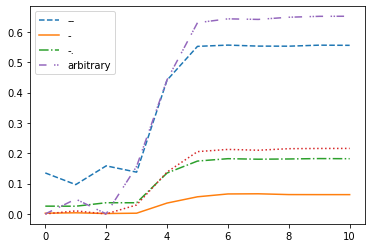

In [11]:
plt.plot(metrics['ap50'][:11],'--',label='--')
plt.plot(metrics['ap75'][:11],'-',label='-')
plt.plot(metrics['ap'][:11],'-.',label='-.')
plt.plot(metrics['Maskap'][:11],':')
plt.plot(metrics['Maskap50'][:11],linestyle=(0,(5,5,1,1,1,1)),label='arbitrary')
plt.legend()
plt.title('this ',fontdict={'fontsize':30})

# plt.plot(metrics['ap'][:11],'-+')

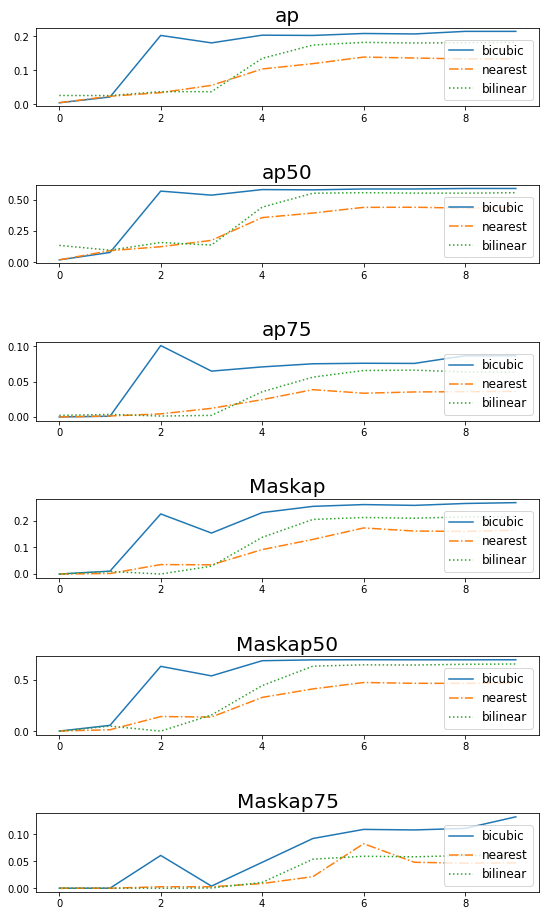

In [11]:
from matplotlib import pyplot as plt
interpols = ['bicubic','nearest','bilinear']
metric_name   = ['ap','ap50','ap75','Maskap','Maskap50','Maskap75']
num_metric    = len(metric_name)
limit         = 10
line_styles   = ['-','-.',':','--']
legend_sizes  = ['xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large']

f, axs = plt.subplots(num_metric, 1, figsize=(9, 15),sharex=False) # w,h

total_met = {}
for j,inter in enumerate(interpols): # ['bicubic','nearest','bilinear']
    exec(f'evaluators={inter}_evals')
    # metrics = {'ap':[], 'ap50':[], 'ap75':[], ..., 'Maskap75':[]}
    metrics = dict(zip( metric_name, list( [] for _ in range(len(metric_name))  )  
                      ))
    # to fill metrics
    for evtor in evaluators:
        for iou_type, coco_eval in evtor.coco_eval.items():
            #coco_eval.summarize()
            #  iou_type : 'bbox' ,'segm'
            if iou_type == 'bbox':
                aps = coco_eval.stats[:3]
                metrics['ap'].append(aps[0])
                metrics['ap50'].append(aps[1])
                metrics['ap75'].append(aps[2])

            else : # 'segm'
                aps = coco_eval.stats[:3]
                metrics['Maskap'].append(aps[0])
                metrics['Maskap50'].append(aps[1])
                metrics['Maskap75'].append(aps[2])
    
    metrics_keys = list(metrics.keys() )
    for i,met_name in enumerate(metrics):
        axs[i].set_title(met_name,fontdict={'fontsize':20})
        axs[i].plot( metrics[met_name][:limit],linestyle=line_styles[j],label=inter)
        axs[i].legend(loc='lower right',fontsize=legend_sizes[4] )
    
    total_met[inter] = metrics
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=1)
# plt.subplots(constrained_layout=True)
    #         coco_eval.stats[:3] # ap ,ap0.5 , ap0.75

# plt.savefig('assets/pf3.jpg')

In [68]:
limit = 12

import pandas as pd
df = pd.DataFrame(columns=list(range(1,limit+1)))

for met in total_met['bicubic'].keys():
    for inter_name in total_met.keys():
        
        item = pd.DataFrame([total_met[inter_name][met][:limit]], columns = list(range(1,limit+1)),index = [f'{met}_{inter_name}'] )
        df = df.append(item)

df.to_csv('./results/pf.csv')

In [41]:
import pandas as pd
num_epoch = 11
aps = []
for inter in interpols:
    exec(f"bbox = {inter}_evals[num_epoch].coco_eval['bbox'].stats[:3]")
    exec(f"segm = {inter}_evals[num_epoch].coco_eval['segm'].stats[:3]")
    row = bbox.tolist()+segm.tolist()
    aps.append(row)
pd.DataFrame(aps,index=interpols,columns=metric_name)

ap      ap50      ap75    Maskap  Maskap50  Maskap75
bicubic   0.214964  0.591654  0.085874  0.266878  0.690976  0.129635
nearest   0.132463  0.433494  0.036978  0.163742  0.464086  0.047593
bilinear  0.181566  0.554535  0.063565  0.215242  0.650762  0.061373

#### balloon 

In [2]:
bicubic_m = get_instance_segmentation_model(num_classes,pretrained=False,mode='bicubic')
bicubic_m.to(device)
m_path = './model/bln_4_bicubic.pth'
bicubic_pter = torch.load(m_path)
# bicubic_m.eval()
# bicubic_m.load_state_dict(bicubic_pter['model_state_dict'])

nearest_m = get_instance_segmentation_model(num_classes,pretrained=False,mode='nearest')
nearest_m.to(device)
m_path = './model/bln_4_nearest.pth'
nearest_pter = torch.load(m_path,map_location=device)
# nearest_m.eval()
# nearest_m.load_state_dict(nearest_pter['model_state_dict'])

device = 'cuda:1'
bilinear_m    = get_instance_segmentation_model(num_classes,pretrained=False,mode='bilinear')
bilinear_m.to(device)
m_path        = './model/bln_4_bilinear.pth'
bilinear_pter = torch.load(m_path)
# bilinear_m.eval()
# bilinear_m.load_state_dict(bilinear_pter['model_state_dict'])

bicubic_evals  = bicubic_pter['evaluators']
nearest_evals  = nearest_pter['evaluators']
bilinear_evals = bilinear_pter['evaluators']

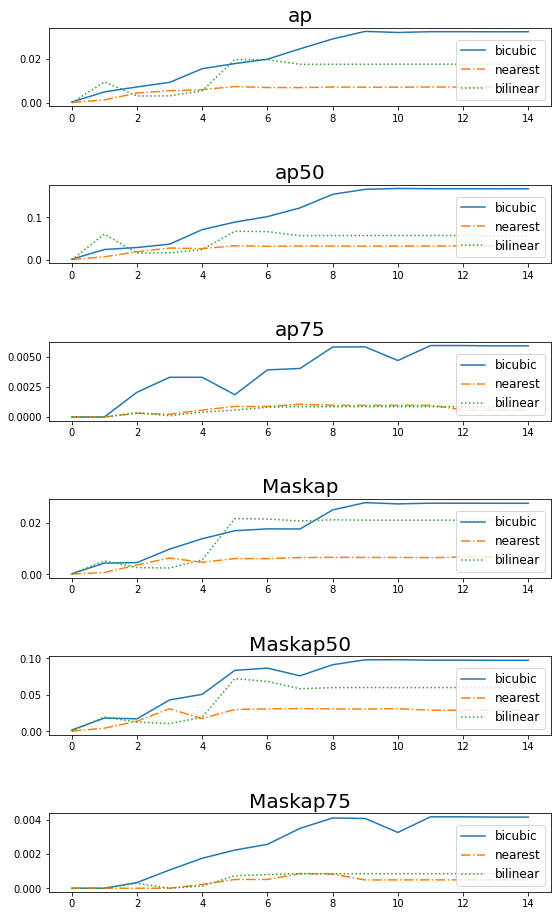

In [3]:
from matplotlib import pyplot as plt
interpols = ['bicubic','nearest','bilinear']
metric_name   = ['ap','ap50','ap75','Maskap','Maskap50','Maskap75']
num_metric    = len(metric_name)
limit     = 15
line_styles   = ['-','-.',':','--']
legend_sizes  = ['xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large']
f, axs = plt.subplots(num_metric, 1, figsize=(9, 15),sharex=False) # w,h

total_met = {}
for j,inter in enumerate(interpols):
    exec(f'evaluators={inter}_evals')
    
    metrics = dict(zip( metric_name, list( [] for _ in range(len(metric_name))  )  
                      ))

    for evtor in evaluators:
        for iou_type, coco_eval in evtor.coco_eval.items():
            #coco_eval.summarize()
            #  iou_type : 'bbox' ,'segm'
            if iou_type == 'bbox':
                aps = coco_eval.stats[:3]
                metrics['ap'].append(aps[0])
                metrics['ap50'].append(aps[1])
                metrics['ap75'].append(aps[2])

            else : # 'segm'
                aps = coco_eval.stats[:3]
                metrics['Maskap'].append(aps[0])
                metrics['Maskap50'].append(aps[1])
                metrics['Maskap75'].append(aps[2])
    
    metrics_keys = list(metrics.keys() )
    for i,met_name in enumerate(metrics):
        axs[i].set_title(met_name,fontdict={'fontsize':20})
        axs[i].plot( metrics[met_name][:limit],linestyle=line_styles[j],label=inter)
        axs[i].legend(loc='lower right',fontsize=legend_sizes[4] )
    total_met[inter] = metrics
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=1)
plt.savefig('assets/bln3.jpg')
# plt.subplots(constrained_layout=True)
    #         coco_eval.stats[:3] # ap ,ap0.5 , ap0.75

In [4]:
limit = 12

import pandas as pd
df = pd.DataFrame(columns=list(range(1,limit+1)))

for met in total_met['bicubic'].keys():
    for inter_name in total_met.keys():
        
        item = pd.DataFrame([total_met[inter_name][met][:limit]], columns = list(range(1,limit+1)),index = [f'{met}_{inter_name}'] )
        df = df.append(item)

df.to_csv('./results/bln.csv')

In [5]:
import pandas as pd
num_epoch = 11
aps = []
for inter in interpols:
    exec(f"bbox = {inter}_evals[num_epoch].coco_eval['bbox'].stats[:3]")
    exec(f"segm = {inter}_evals[num_epoch].coco_eval['segm'].stats[:3]")
    row = bbox.tolist()+segm.tolist()
    aps.append(row)
pd.DataFrame(aps,index=interpols,columns=metric_name)

ap      ap50      ap75    Maskap  Maskap50  Maskap75
bicubic   0.032478  0.166551  0.005963  0.027694  0.097201  0.004160
nearest   0.007204  0.032603  0.000968  0.006438  0.028716  0.000486
bilinear  0.017642  0.057108  0.000860  0.021060  0.059672  0.000850